# Binary Classification
The goal is to classify a picture between two classes : an Boing 747 or an Airbus A380

There is a nice script to get images from Google : https://github.com/boxabirds/fastai-helpers/blob/master/training-data-generator.py, it's based on https://github.com/hardikvasa/google-images-download wich use ChromeDriver to automate the process.

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#PATH = "../../datasets/boing_vs_airbus/"
PATH = "../../datasets/A380_vs_A330/"

In [3]:
## Getting dataset
#!mkdir ../../datasets/boing_vs_airbus
#!pip install google_images_download
#!ls ../../datasets/
#!cd {PATH} && mkdir -p train/747 train/A380 test/747 test/A380  valid/747 valid/A380
#!cd {PATH}/747 && googleimagesdownload --keywords "Boing 747" --limit 1000 --chromedriver /usr/local/bin/chromedriver
#!cd {PATH}/A380 && googleimagesdownload --keywords "Airbus A380" --limit 1000 --chromedriver /usr/local/bin/chromedriver
## Getting models weights
#!cd ./fastai && wget http://files.fast.ai/models/weights.tgz && tar -xvzf weights.tgz
!ls {PATH}

train  valid


In [4]:
print("Setting CUDA devices...")
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="6"
print("Loading Fast.AI modules...")
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *


sz=299
arch=resnet34
#arch=resnext50
bs=132

Setting CUDA devices...
Loading Fast.AI modules...


/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [5]:
print("CuDNN optimization is ", torch.backends.cudnn.enabled)

CuDNN optimization is  True


Data augmentation options : https://becominghuman.ai/data-augmentation-using-fastai-aefa88ca03f1

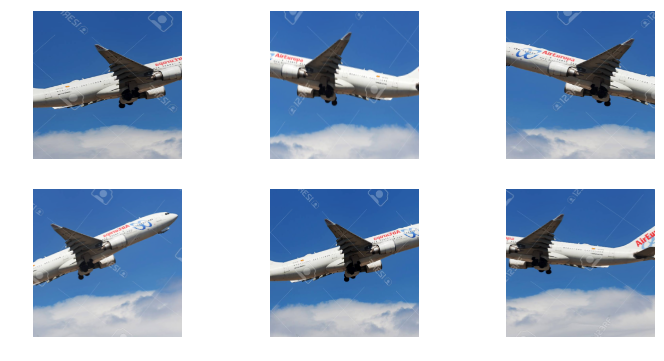

In [9]:

aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO),
        RandomFlip(),
        RandomLighting(0.05, 0.05,tfm_y=TfmType.NO),
        RandomZoom(zoom_max=0.2),
        RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=16)

def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=16)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]
ims = np.stack([get_augs() for i in range(6)])
plots(ims, rows=2)

In [10]:

learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)
lrf=learn.lr_find()

100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


epoch      trn_loss   val_loss   accuracy               
    0      0.926459   46.032531  0.378505  



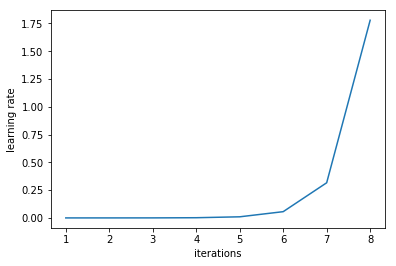

In [11]:
learn.sched.plot_lr()

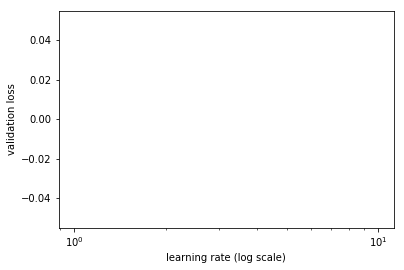

In [12]:
learn.sched.plot()

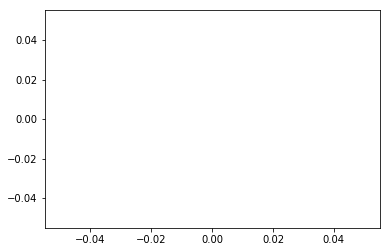

In [13]:
learn.sched.plot_loss()

In [22]:
learn.precompute=False

lr=np.array([1e-4,1e-3,1e-2])
learn.unfreeze()
vals_s2s, ep_vals_s2s = learn.fit(lr, 3, cycle_len=1, cycle_mult=2, get_ep_vals=True)

epoch      trn_loss   val_loss   accuracy                
    0      0.416732   0.424128   0.817757  
    1      0.402896   0.394813   0.82243                 
    2      0.382837   0.385      0.827103                
    3      0.369897   0.349684   0.850467                
    4      0.348111   0.325678   0.869159                
    5      0.325877   0.312736   0.878505                
    6      0.315693   0.31121    0.878505                



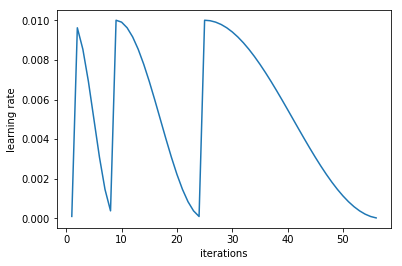

In [15]:
learn.sched.plot_lr()

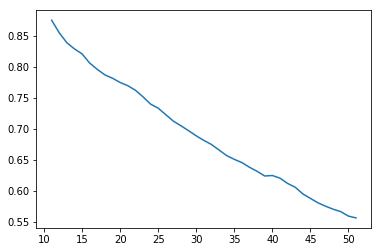

In [16]:
learn.sched.plot_loss()

In [17]:
learn.save(arch.__name__ + '_' + str(sz) +'_weights')

In [18]:
len(learn.sched.losses)

56

In [38]:
ep_vals_s2s.values()

odict_values([[0.416732, 0.424128, 0.817757], [0.402896, 0.394813, 0.82243], [0.382837, 0.385, 0.827103], [0.369897, 0.349684, 0.850467], [0.348111, 0.325678, 0.869159], [0.325877, 0.312736, 0.878505], [0.315693, 0.31121, 0.878505]])

In [40]:
len(ep_vals_s2s)

7

In [21]:
vals_s2s

array([0.42653])

In [47]:
list(ep_vals_s2s)

[0, 1, 2, 3, 4, 5, 6]

[0, 1, 2, 3, 4, 5, 6]
[0.416732, 0.402896, 0.382837, 0.369897, 0.348111, 0.325877, 0.315693]
[0.424128, 0.394813, 0.385, 0.349684, 0.325678, 0.312736, 0.31121]


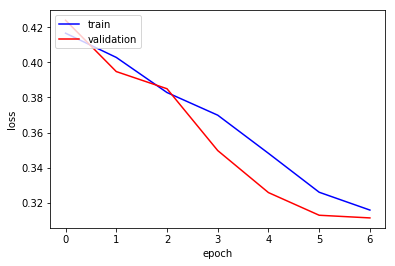

In [52]:
def plot_ep_vals(ep_vals):
    plt.ylabel("loss")
    plt.xlabel("epoch")
    epochs = len(ep_vals)#ep_vals.keys()
    #plt.xticks(np.asarray(list(epochs)))
    plt.xticks((list(ep_vals)))
    print((list(ep_vals)))
    trn_losses = [item[0] for item in list(ep_vals.values())]
    print(trn_losses)
    val_losses = [item[1] for item in list(ep_vals.values())]
    print(val_losses)
    plt.plot(list(ep_vals), trn_losses, c='b', label='train')
    plt.plot(list(ep_vals), val_losses, c='r', label='validation')
    plt.legend(loc='upper left')
plot_ep_vals(ep_vals_s2s)

[[ 97  14]                                   
 [  3 100]]


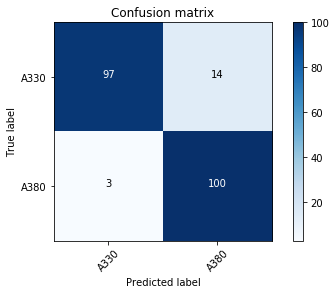

In [23]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)
preds = np.argmax(probs, axis=1)
probs = probs[:,1]
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

In [24]:
# This is the label for a val data
data.val_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [25]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

['A330', 'A380']

In [26]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(214, 2)

In [27]:
log_preds[:10]

array([[-0.04828, -3.05471],
       [-0.01585, -4.15281],
       [-0.34174, -1.23972],
       [-0.3015 , -1.34594],
       [-0.00813, -4.81613],
       [-0.00255, -5.97471],
       [-0.04915, -3.03732],
       [-0.01465, -4.2304 ],
       [-0.55279, -0.85647],
       [-0.04631, -3.09547]], dtype=float32)

In [28]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [29]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

Correctly classified


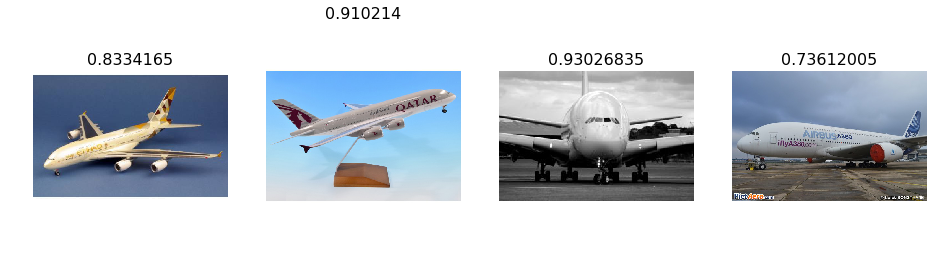

In [30]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


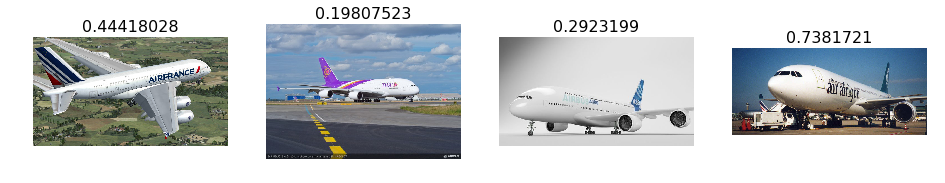

In [31]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [32]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct 747


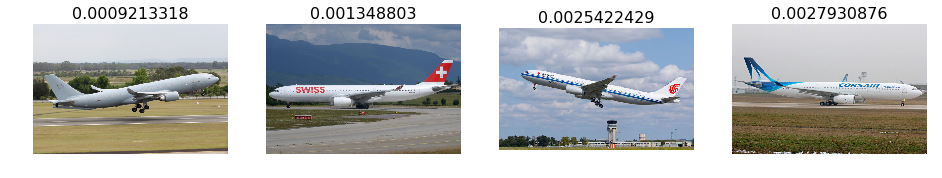

In [33]:
plot_val_with_title(most_by_correct(0, True), "Most correct 747")

Most correct A380


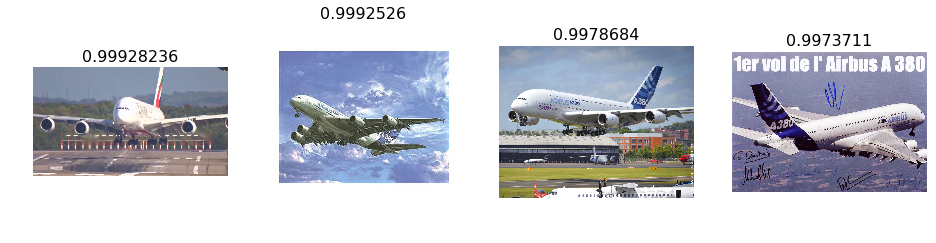

In [34]:
plot_val_with_title(most_by_correct(1, True), "Most correct A380")

Most incorrect 747


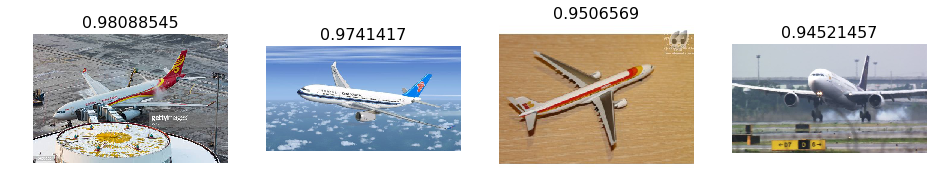

In [35]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect 747")

Most incorrect A380


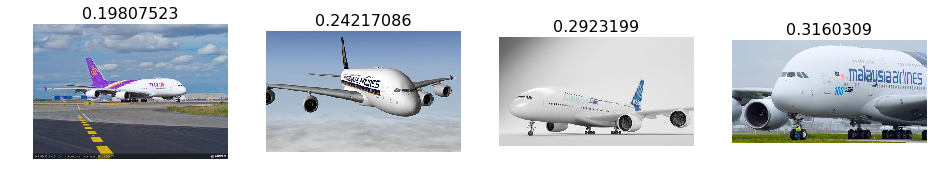

In [36]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect A380")

Most uncertain predictions


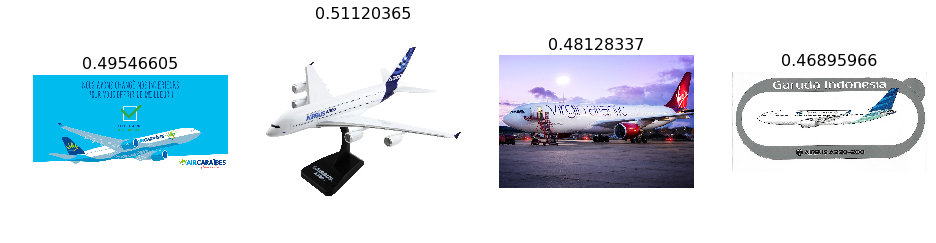

In [37]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")